# Projection of the update frequency

The goal of this part is to define how long will it take for the initial model to become obsolete in order to train a new one. For this purpose, the dataset will de divided in several parts:

- the "base" dataset covering orders from 2016 to the end of 2017 to train the initial model, the idea is to have a complete year of orders
- incremental datasets starting from 2018 (base dataset incremented by 10 days in each iteration till the end of the dataset)

The main idea is to train each incremental dataset with a new model and with the initial model in order to compare the ARI scores of the predicted labels. When the ARI score goes below 0.8, it means that the model becomes outdated and should be trained again.



# Imports

## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, jaccard_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster.elbow import kelbow_visualizer

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

sns.set_style('whitegrid', {'grid.linewidth': .05, 'grid.color': '.85'})

## Data

All the data imports and transformations will be done from scratch (not using the RFM export) to simulate production context.

**Orders**

In [3]:
df_orders = pd.read_csv('data/source/olist_orders_dataset.csv')
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


**Customers**

In [5]:
df_customers = pd.read_csv('data/source/olist_customers_dataset.csv')
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


**Payments**

In [6]:
df_payments = pd.read_csv('data/source/olist_order_payments_dataset.csv')
df_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.3300
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.3900
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.7100
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.7800
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.4500
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.3100
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.8000
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.7700
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.5400


**Reviews**

In [10]:
df_reviews = pd.read_csv('data/source/olist_order_reviews_dataset.csv')
df_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


# Preprocessing

## Prepare datasets


In [8]:
df_orders['order_purchase_timestamp'] = df_orders['order_purchase_timestamp'].apply(
    pd.to_datetime)

In [9]:
df_payments_grouped = df_payments.groupby(
    'order_id')['payment_value'].sum().reset_index()

In [33]:
df_reviews_grouped = df_reviews.groupby(
    'order_id')['review_score'].mean().round(2).reset_index()

## Transforming

Create the following functions for the data preprocessing:

1. get orders for a period of time passed in argument
2. merge orders dataset with customers, payments and reviews
3. clean the dataset
4. create an RFM dataset grouped by customer


In [12]:
def get_orders_for_period(nb_days):
    '''Returns the orders purchased for a period given in number of days'''

    min_date = df_orders['order_purchase_timestamp'].min()
    end_date = min_date + np.timedelta64(nb_days, 'D')

    return df_orders.loc[df_orders['order_purchase_timestamp'] < end_date, :]

In [87]:
def merge_datasets(data_orders):
    '''Returns a merged orders dataset with customers, payments, reviews datasets'''

    return (
        data_orders
        .merge(df_customers, on='customer_id')
        .merge(df_payments_grouped, on='order_id')
        .merge(df_reviews_grouped, on='order_id', how='left')
    )

In [90]:
def clean_dataset(df):
    '''Fill missing values and keep the most relevant features'''

    df['review_score'] = df['review_score'].fillna(df['review_score'].mean())

    features_to_keep = [
        'order_id', 'customer_id', 'customer_unique_id',
        'order_purchase_timestamp', 'payment_value', 'review_score'
    ]

    return df[features_to_keep]

In [36]:
def create_rfm_dataset(df):
    '''Returns a dataset grouped by customer with calculated RFM values'''

    max_purchase_date = df['order_purchase_timestamp'].max()

    return df.groupby('customer_unique_id').agg(
        recency=pd.NamedAgg(column="order_purchase_timestamp",
                            aggfunc=lambda x:
                            (max_purchase_date - x.max()).days),
        frequency=pd.NamedAgg(column='order_id',
                              aggfunc=lambda x: x.nunique()),
        monetary=pd.NamedAgg(column='payment_value', aggfunc="sum"),
        satisfaction=pd.NamedAgg(column='review_score', aggfunc="mean")
    )

In [37]:
def get_rfm_dataset_for_period(nb_days):
    '''Returns an RFM aggregated dataset for the given period in days'''

    # get orders for the given period
    df = get_orders_for_period(nb_days)

    # merge the order dataset with customers and payments datasets
    df = merge_datasets(df)

    # clean dataset
    df = clean_dataset(df)

    # create a RFM dataset
    df_rfm = create_rfm_dataset(df)

    return df_rfm

# Clustering simulation

## Base dataset

Get the "base" dataset: orders from the beginning till the end of 2017, it will contain less than a half of all orders.

In [57]:
total_days = (df_orders['order_purchase_timestamp'].max(
) - df_orders['order_purchase_timestamp'].min()).days
print(f'total period in days: {total_days}')

base_end_date = pd.to_datetime('2017-12-31')
total_days_base = (
    base_end_date - df_orders['order_purchase_timestamp'].min()).days

print(f'base period in days: {total_days_base}')

total period in days: 772
base period in days: 482


In [91]:
df_rfm_base = get_rfm_dataset_for_period(total_days_base)
df_rfm_base.shape

(43954, 4)

In [92]:
df_rfm_base

,recency,frequency,monetary,satisfaction
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,295,1,86.2200,3.0000
0000f6ccb0745a6a4b88665a16c9f078,79,1,43.6200,4.0000
0004aac84e0df4da2b147fca70cf8255,46,1,196.8900,5.0000
0005e1862207bf6ccc02e4228effd9a0,300,1,150.1200,4.0000
0006fdc98a402fceb4eb0ee528f6a8d4,165,1,29.0000,3.0000
...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,2,1,167.3200,5.0000
fffcf5a5ff07b0908bd4e2dbc735a684,205,1,2067.4200,5.0000
fffea47cd6d3cc0a88bd621562a9d061,20,1,84.5800,4.0000


In [93]:
df_rfm_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43954 entries, 0000f46a3911fa3c0805444483337064 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recency       43954 non-null  int64  
 1   frequency     43954 non-null  int64  
 2   monetary      43954 non-null  float64
 3   satisfaction  43954 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.7+ MB


Scale the data

In [99]:
np.set_printoptions(suppress=True)

scaler_base = StandardScaler()
X_base_scaled = scaler_base.fit_transform(df_rfm_base)
X_base_scaled

array([[ 1.58111988, -0.15975688, -0.33762674, -0.81239262],
       [-0.60313832, -0.15975688, -0.51780459, -0.06103665],
       [-0.93684444, -0.15975688,  0.13045503,  0.69031932],
       ...,
       [-1.19976441, -0.15975688, -0.34456316, -0.06103665],
       [ 1.89460139, -0.15975688, -0.22664394,  0.69031932],
       [ 1.04516764, -0.15975688, -0.3996316 ,  0.69031932]])

Train the base dataset with KMeans with 5 clusters

In [100]:
model_base = KMeans(n_clusters=5, random_state=0, n_init=10)
y_base = model_base.fit_predict(X_base_scaled)
score_base = silhouette_score(X_base_scaled, y_base)

print(score_base)

0.4229630506066532


## Incremented datasets

Train the incremented datasets with both base model and new model, store the scores and compare them


In [105]:
scores = []
interval = 10

for nb_days in range(total_days_base + interval, total_days, interval):
    # get the sample for the interval
    df_rfm_next = get_rfm_dataset_for_period(nb_days)

    # train it with a new model
    scaler_next = StandardScaler()
    X_rfm_next_scaled = scaler_next.fit_transform(df_rfm_next)

    model_rfm_next = KMeans(n_clusters=5, random_state=0, n_init=10)
    y_rfm_next = model_rfm_next.fit_predict(X_rfm_next_scaled)

    # predict with the base model
    X_rfm_next_scaled_on_base = scaler_base.transform(df_rfm_next)
    y_rfm_next_on_base = model_base_scaled.predict(X_rfm_next_scaled_on_base)

    # compare Y trained on the base model with the Y trained on the new model
    ari = adjusted_rand_score(y_rfm_next_on_base, y_rfm_next)
    scores.append({'interval': nb_days, 'ari': ari})
    print(f'the score for {nb_days} days: {ari}')

the score for 492 days: 0.9084430854096733
the score for 502 days: 0.8913644699712862
the score for 512 days: 0.8573942515624878
the score for 522 days: 0.8460736701189824
the score for 532 days: 0.807503887046149
the score for 542 days: 0.7820186951685264
the score for 552 days: 0.7481376194541012
the score for 562 days: 0.7078372391137466
the score for 572 days: 0.7285989447695177
the score for 582 days: 0.7108883048530302
the score for 592 days: 0.6820096655216896
the score for 602 days: 0.6179399189609548
the score for 612 days: 0.5803045798220465
the score for 622 days: 0.5640180232873971
the score for 632 days: 0.5433554270442923
the score for 642 days: 0.5256876749121956
the score for 652 days: 0.4890378533733465
the score for 662 days: 0.4627447626128946
the score for 672 days: 0.4380725768275138
the score for 682 days: 0.42051683156626024
the score for 692 days: 0.4112252410099208
the score for 702 days: 0.4101291074552462
the score for 712 days: 0.46915673799018925
the score 

In [106]:
df_scores = pd.DataFrame(scores)
df_scores

,interval,ari
0,492,0.9084
1,502,0.8914
2,512,0.8574
3,522,0.8461
4,532,0.8075
5,542,0.7820
6,552,0.7481
7,562,0.7078
8,572,0.7286
9,582,0.7109


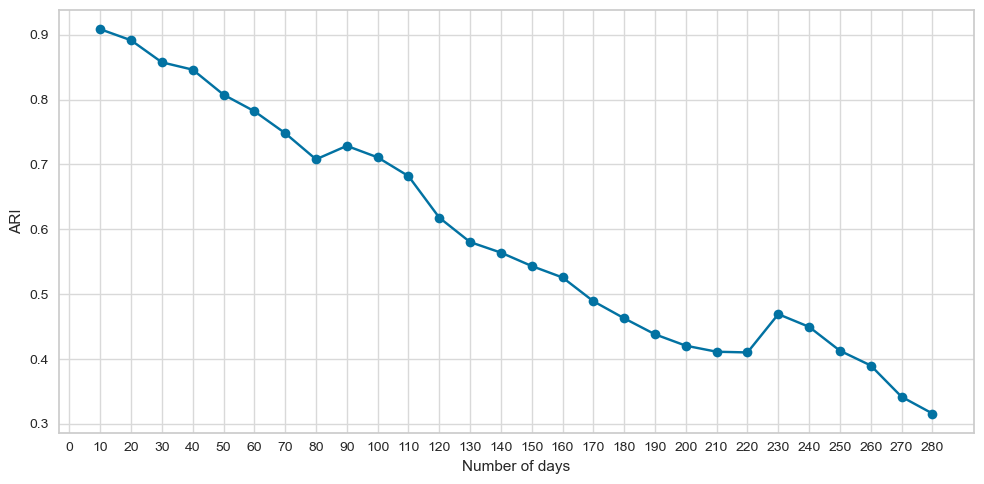

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(df_scores['interval'], df_scores['ari'], marker="o")
ax.set_xlabel("Number of days")
ax.set_ylabel("ARI")
plt.xticks(np.arange(total_days_base, total_days, interval))
ax.xaxis.set_major_formatter(lambda x, pos: str(x-total_days_base))

fig.tight_layout()

**Conclusion**

We see that the ARI steadily goes down, it drops below 0.8 after 50 days, therefore the recommendation would be to re-train the model at this frequency at the most.